In [1]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [89]:
def get_data_fromString(filename, regular_mask, data_name=None):
    match = re.search(regular_mask, filename)

    if match:
        data = float(match.group(1))
        print(f"Current data{('(' + data_name + ')') if data_name is not None else ''}:", data)
    else:
        print(f"Data{('(' + data_name + ')') if data_name is not None else ''} is not found")
        try:
            data = float(input(f"Input data{('(' + data_name + ')') if data_name is not None else ''}: "))
            print(f"Current data{('(' + data_name + ')') if data_name is not None else ''}:", data)
        except Exception as e:
            print(e)
            data = 0.1
            print(f"Data set as {data}")
    print()
    return data


def pack_df_fromArrays(data):
    N, M = data["growth"].shape

    data_arr = []
    for i in range(N):
        for j in range(M):
            data_arr.append([data["A"][i], data["P"][j], data["growth"][i, j]])
    return pd.DataFrame(data_arr, columns=['A', 'P', 'growth'])


def get_data_fromNPZ(filename):
    data = np.load(f'data/{filename}')

    triangularity = get_data_fromString(filename, r"triangularity=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)[^0-9]",
                                        "triangularity")
    elongation = get_data_fromString(filename, r"elongation=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)[^0-9]",
                                     "elongation")
    I = get_data_fromString(filename, r"I=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)[^0-9]", "I")
    B = get_data_fromString(filename, r"B=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)[^0-9]", "B")

    df_ = pack_df_fromArrays({"A": data["delta_arr"],
                              "P": data["p_multy_arr"],
                              "growth": data["growth"]})

    plot_diagram(data["delta_arr"], data["p_multy_arr"], data["growth"], data["unstable_mode"],
                 meta={'sigma': triangularity,
                       'kappa': elongation,
                       'I': I,
                       'B': B,
                       'growth_edge': 0.1})
    # , data["unstable_mode"]

    return triangularity, elongation, I, B, data["delta_arr"], data["p_multy_arr"], data["growth"], df_


def get_data_fromDAT(index=""):
    index_A = pd.read_table(f"data/A{index}.dat", sep=' ', header=None).to_numpy()[:, 0]
    header_P = pd.read_table(f"data/P{index}.dat", sep=' ', header=None).to_numpy()[0]

    growth = pd.read_table(f"data/growth{index}.dat", sep=' ', header=None)
    mode = pd.read_table(f"data/unstable_mode{index}.dat", sep=' ', header=None)

    triangularity = get_data_fromString(index, r"triangularity=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)[^0-9]",
                                        "triangularity")
    elongation = get_data_fromString(index, r"elongation=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)[^0-9]",
                                     "elongation")
    I = get_data_fromString(index, r"I=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)[^0-9]", "I")
    B = get_data_fromString(index, r"B=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)[^0-9]", "B")

    df_ = pack_df_fromArrays({"A": index_A,
                              "P": header_P,
                              "growth": growth.to_numpy()})

    plot_diagram(index_A, header_P, growth.to_numpy(), mode.to_numpy(), meta={'sigma': triangularity,
                                                                              'kappa': elongation,
                                                                              'I': I,
                                                                              'B': B,
                                                                              'growth_edge': 0.1})
    # , index_A, header_P, growth.to_numpy(), mode.to_numpy()

    return triangularity, elongation, I, B, index_A, header_P, growth.to_numpy(), df_


def get_isoline(np_growth, df_data, growth_edge):
    zero_mask = abs(np_growth - growth_edge) < np_growth.std() / 4
    plot_data = df_data[zero_mask, :]

    plot_x = [plot_data[0, 0]]
    plot_y = [plot_data[0, 1]]
    plot_z = [plot_data[0, 2]]
    n_of_same_x = 1
    for x, y, z in plot_data[1:, :3]:
        if x == plot_x[-1]:
            plot_y[-1] += y
            plot_z[-1] += z
            n_of_same_x += 1
        else:
            plot_y[-1] /= n_of_same_x
            plot_z[-1] /= n_of_same_x

            plot_x.append(x)
            plot_y.append(y)
            plot_z.append(z)
            n_of_same_x = 1

    plot_y[-1] /= n_of_same_x
    plot_z[-1] /= n_of_same_x

    return plot_x, plot_y, plot_z


def plot_diagram(A_data, P_data, growth_data, mode_data, meta):

    df = pack_df_fromArrays({"A": A_data,
                             "P": P_data,
                             "growth": growth_data})

    plot_x, plot_y, plot_z = get_isoline(df.growth.to_numpy(), df.to_numpy(), meta["growth_edge"])

    fig, ax = plt.subplots()
    fig.set_figwidth(8)
    fig.set_figheight(7)

    pcm = ax.pcolormesh(A_data, P_data, growth_data.T, cmap='winter')
    fig.colorbar(pcm, ax=ax)

    X, Y = np.meshgrid(A_data, P_data)
    # print(X)
    # print(Y)
    for i in range(1, P_data.shape[0]):
        for j in range(1, P_data.shape[0]):
            ax.annotate(f"{mode_data[i, j].astype(int)}",
                        (X.flat[(i - 1) * P_data.shape[0] + j - 1], Y.flat[(i - 1) * P_data.shape[0] + j]),
                        textcoords="offset points",
                        fontsize=10, xytext=(5, 7), alpha=0.6)

    # ax.plot(plot_data[:, 0], plot_data[:, 1], marker="+", label='Direct', alpha=0.8)
    # for i, (xi, yi) in enumerate(zip(plot_data[:, 0], plot_data[:, 1])):
    #     ax.annotate(f"{plot_data[i, 2]:.2f}",
    #                  (xi, yi), textcoords="offset points",
    #                  fontsize=8, xytext=(-8, 5))

    ax.plot(plot_x, plot_y, marker=".", c="orange")  # , label='Average', alpha=0.8, linewidth=.5
    for i, (xi, yi) in enumerate(zip(plot_x, plot_y)):
        ax.annotate(f"{plot_z[i]:.2f}",
                    (xi, yi), textcoords="offset points",
                    fontsize=8, xytext=(-8, (5 if i % 2 else -11)), c="k")

    # ax2.legend()
    # ax.set_xlim([df.A.min(), df.A.max()])
    # ax.set_ylim([df.P.min(), df.P.max()])

    # ax.grid(which='major', color='#DDDDDD', linewidth=0.9)
    # ax.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.7)
    # ax.minorticks_on()
    # ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    # ax.yaxis.set_minor_locator(AutoMinorLocator(10))

    ax.set_title(
        f"$\\sigma$={meta['sigma']}, $\\kappa$={meta['kappa']}, $I$={meta['I']} $kA$, $B$={meta['B']} $T$\nIsoline by growth: {meta['growth_edge']}")

    plt.show()

def variate_points(points, n, var_x, var_y):
    rng = np.random.default_rng(seed=42)
    new_points = []
    for i in range(points.shape[0]):
        variances = 2 * rng.random((n, 2)) - 1
        variate_from_point = np.stack([points[i, 0] + variances[:, 0] * var_x, points[i, 1] + variances[:, 1] * var_y], axis=1)
        new_points.append(variate_from_point)
    return np.concatenate(new_points)

Data(triangularity) is not found


Input data(triangularity):  0.35


Current data(triangularity): 0.35

Data(elongation) is not found


Input data(elongation):  1.83


Current data(elongation): 1.83

Data(I) is not found


Input data(I):  400


Current data(I): 400.0

Data(B) is not found


Input data(B):  0.8


Current data(B): 0.8



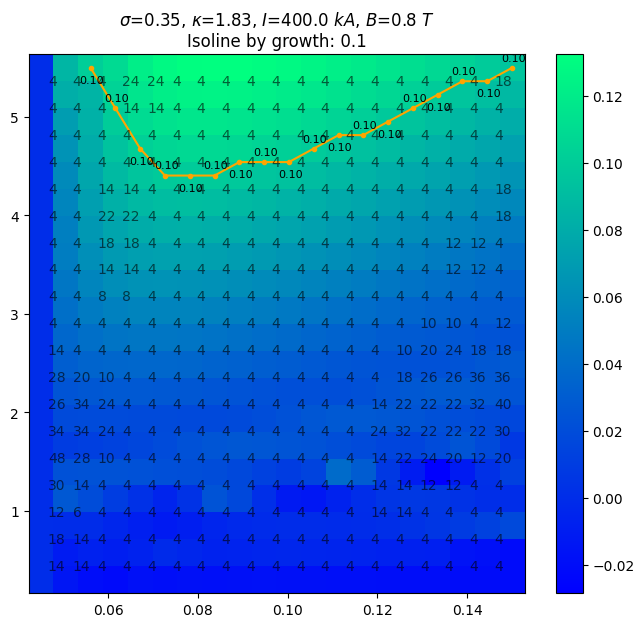

0.35 1.83 400.0 0.8


In [91]:
filename = "output-data_triangularity=2.1e-1.npz"

sigma, kappa, I, B, x, y, growth, df = get_data_fromDAT()  # get_data_fromNPZ(filename)  # 

print(sigma, kappa, I, B)

In [81]:
df["sigma"] = sigma
df["kappa"] = kappa
df["I_kA"] = I
df["B_T"] = B

growth_edge = 0.1
df["mark"] = (df.growth.to_numpy() > growth_edge).astype(int)
df.head(100)

,A,P,growth,sigma,kappa,I_kA,B_T,mark
0,0.010000,0.10000,0.000000,0.21,1.9,300.0,0.7,0
1,0.010000,0.18947,0.000000,0.21,1.9,300.0,0.7,0
2,0.010000,0.27895,0.000000,0.21,1.9,300.0,0.7,0
3,0.010000,0.36842,0.000000,0.21,1.9,300.0,0.7,0
4,0.010000,0.45789,0.000000,0.21,1.9,300.0,0.7,0
...,...,...,...,...,...,...,...,...
95,0.033158,1.44211,0.206525,0.21,1.9,300.0,0.7,1
96,0.033158,1.53158,0.228127,0.21,1.9,300.0,0.7,1
97,0.033158,1.62105,0.255845,0.21,1.9,300.0,0.7,1
98,0.033158,1.71053,0.276369,0.21,1.9,300.0,0.7,1


In [83]:
df_train = df.drop("growth", axis=1)

index = "2"
df_train.to_csv(f"data/train/train_{index}.csv", index=False)

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       400 non-null    float64
 1   P       400 non-null    float64
 2   sigma   400 non-null    float64
 3   kappa   400 non-null    float64
 4   I_kA    400 non-null    float64
 5   B_T     400 non-null    float64
 6   mark    400 non-null    int32  
dtypes: float64(6), int32(1)
memory usage: 20.4 KB


---

In [101]:
from scipy.interpolate import RBFInterpolator

x_, y_ = np.meshgrid(x[1:], y[1:])
xobs = np.stack([x_.flat, y_.flat], axis=1)
yobs = growth[1:, 1:].T.reshape(-1)

interpolator = RBFInterpolator(xobs, yobs)

plot_x, plot_y, plot_z = get_isoline(df.growth.to_numpy(), df[["A", "P", "growth"]].to_numpy(), growth_edge)

xflat = variate_points(np.stack([plot_x, plot_y], axis=1), 25, var_x=0.0015, var_y=0.05)
yflat = interpolator(xflat)

df_aug = pd.DataFrame(np.stack([xflat[:, 0], xflat[:, 1], yflat], axis=1), columns=['A', 'P', 'growth'])

df_aug["sigma"] = sigma
df_aug["kappa"] = kappa
df_aug["I_kA"] = I
df_aug["B_T"] = B

df_aug["mark"] = (df_aug.growth.to_numpy() > growth_edge).astype(int)
print("1: ", np.count_nonzero(df_aug.growth.to_numpy() > growth_edge), "0: ", np.count_nonzero(df_aug.growth.to_numpy() < growth_edge))
print("---")
df_aug.head(100)

1:  72 0:  378
---


,A,P,growth,sigma,kappa,I_kA,B_T,mark
0,0.056876,5.493888,0.101527,0.35,1.83,400.0,0.8,1
1,0.057130,5.519737,0.095890,0.35,1.83,400.0,0.8,0
2,0.054836,5.547562,0.081927,0.35,1.83,400.0,0.8,0
3,0.056837,5.528606,0.092009,0.35,1.83,400.0,0.8,0
4,0.054938,5.495039,0.097699,0.35,1.83,400.0,0.8,0
...,...,...,...,...,...,...,...,...
95,0.073934,4.379360,0.087070,0.35,1.83,400.0,0.8,0
96,0.071492,4.438375,0.082705,0.35,1.83,400.0,0.8,0
97,0.071584,4.373190,0.081903,0.35,1.83,400.0,0.8,0
98,0.072922,4.442720,0.081625,0.35,1.83,400.0,0.8,0


In [93]:
df_aug_train = df_aug.drop("growth", axis=1)

index = "3"
df_aug_train.to_csv(f"data/train/train_{index}_aug.csv", index=False)

df_aug_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       450 non-null    float64
 1   P       450 non-null    float64
 2   sigma   450 non-null    float64
 3   kappa   450 non-null    float64
 4   I_kA    450 non-null    float64
 5   B_T     450 non-null    float64
 6   mark    450 non-null    int32  
dtypes: float64(6), int32(1)
memory usage: 23.0 KB


---
---

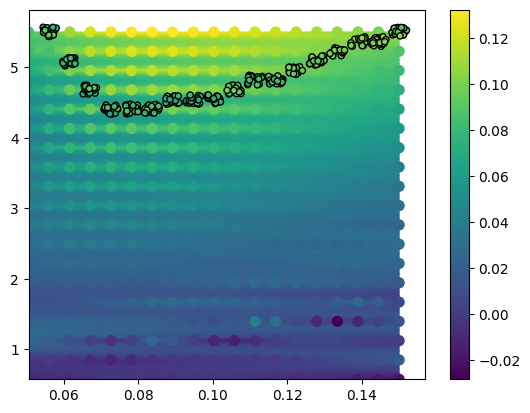

In [94]:
from scipy.interpolate import RBFInterpolator

x_, y_ = np.meshgrid(x[1:], y[1:])
xobs = np.stack([x_.flat, y_.flat], axis=1)
yobs = growth[1:, 1:].T.reshape(-1)

interpolator = RBFInterpolator(xobs, yobs)

plot_x, plot_y, plot_z = get_isoline(df.growth.to_numpy(), df[["A", "P", "growth"]].to_numpy(), growth_edge)

n_new = 100j
xgrid_ = np.mgrid[x_.min():x_.max():n_new, y_.min():y_.max():n_new]
xflat_ = xgrid_.reshape(2, -1).T
yflat_ = interpolator(xflat_)
ygrid_ = yflat_.reshape(int(n_new.imag), int(n_new.imag))

xflat = variate_points(np.stack([plot_x, plot_y], axis=1), 20, var_x=0.002, var_y=0.07)
yflat = interpolator(xflat)

fig, ax = plt.subplots()
z_min, z_max = growth.min(), growth.max()
ax.pcolormesh(*xgrid_, ygrid_, shading='gouraud', vmin=z_min, vmax=z_max)
ax.scatter(*xobs.T, c=growth[1:, 1:].T.reshape(-1), s=50, vmin=z_min, vmax=z_max)
p = ax.scatter(*xflat.T, c=yflat, s=20, vmin=z_min, vmax=z_max, ec="k")  # , ec="k"
fig.colorbar(p)
plt.show()

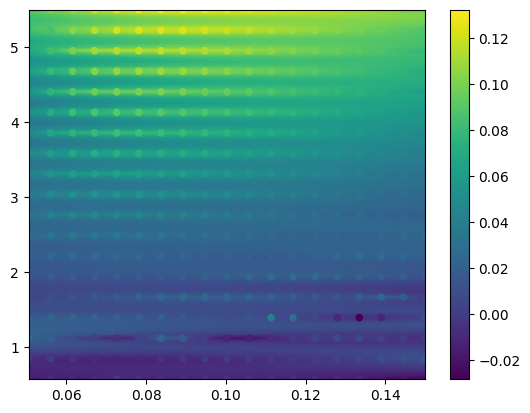

In [95]:
from scipy.interpolate import RBFInterpolator

x_, y_ = np.meshgrid(x[1:], y[1:])
xobs = np.stack([x_.flat, y_.flat], axis=1)
yobs = growth[1:, 1:].T.reshape(-1)

n_new = 100j
xgrid = np.mgrid[x_.min():x_.max():n_new, y_.min():y_.max():n_new]
xflat = xgrid.reshape(2, -1).T
yflat = RBFInterpolator(xobs, yobs)(xflat)
ygrid = yflat.reshape(int(n_new.imag), int(n_new.imag))

fig, ax = plt.subplots()
ax.pcolormesh(*xgrid, ygrid, shading='gouraud')
p = ax.scatter(*xobs.T, c=growth[1:, 1:].T.reshape(-1), s=20)
fig.colorbar(p)
plt.show()